<a href="https://colab.research.google.com/github/jaeyoonjeong9024/6weeks/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# 전체 CIFAR-10 데이터 로드
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# 클래스 정의 및 선택 ('cat', 'dog', 'horse')
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
selected_classes = ['cat', 'dog', 'horse']
selected_idx = [class_names.index(c) for c in selected_classes]

# 선택된 클래스 데이터만 필터링
train_mask = np.isin(y_train, selected_idx).flatten()
test_mask = np.isin(y_test, selected_idx).flatten()
x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

# 라벨을 0, 1, 2로 재매핑
label_map = {v: i for i, v in enumerate(selected_idx)}
y_train = np.array([label_map[int(y)] for y in y_train])
y_test = np.array([label_map[int(y)] for y in y_test])

# 0~1 사이로 정규화
x_train, x_test = x_train / 255.0, x_test / 255.0

print(f"✓ 데이터 준비 완료: {len(x_train)}개의 학습 샘플, {len(x_test)}개의 테스트 샘플")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
✓ 데이터 준비 완료: 15000개의 학습 샘플, 3000개의 테스트 샘플


/tmp/ipython-input-951117379.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_train = np.array([label_map[int(y)] for y in y_train])
/tmp/ipython-input-951117379.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test = np.array([label_map[int(y)] for y in y_test])


In [3]:
model = models.Sequential([
    # 데이터 증강은 정확도에 중요하므로 유지
    layers.RandomFlip("horizontal", input_shape=(32, 32, 3)),
    layers.RandomRotation(0.1),

    # 모델 구조를 더 가볍게 수정
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), # 과적합 방지
    layers.Dense(3, activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 544,195 (2.08 MB)

 Trainable params: 544,195 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 콜백 (patience를 3으로 짧게 설정)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습 (epochs와 batch_size 조절)
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 264ms/step - accuracy: 0.4765 - loss: 1.0056 - val_accuracy: 0.5977 - val_loss: 0.8421
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 248ms/step - accuracy: 0.5893 - loss: 0.8511 - val_accuracy: 0.6370 - val_loss: 0.7793
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.6343 - loss: 0.7968 - val_accuracy: 0.6650 - val_loss: 0.7262
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 248ms/step - accuracy: 0.6552 - loss: 0.7570 - val_accuracy: 0.6900 - val_loss: 0.7060
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 248ms/step - accuracy: 0.6691 - loss: 0.7302 - val_accuracy: 0.6870 - val_loss: 0.7006
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - accuracy: 0.6732 - loss: 0.7218 - val_accuracy: 0.6977 - val_loss: 0.6922
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 42s 257ms/step - accuracy: 0.6914 - loss: 0.6935 - val_accuracy: 0.7000 - val_loss: 0.6690
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 261ms/step - accuracy: 0.7035 - loss: 0

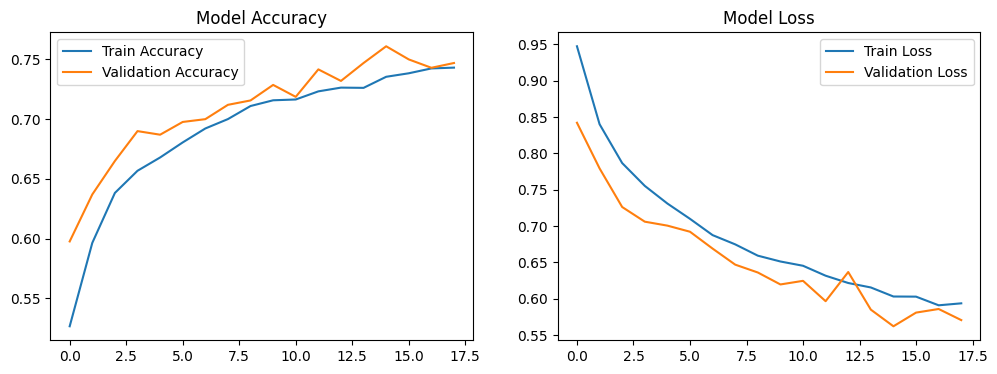

94/94 - 2s - 23ms/step - accuracy: 0.7610 - loss: 0.5622

최종 테스트 정확도: 76.10%
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


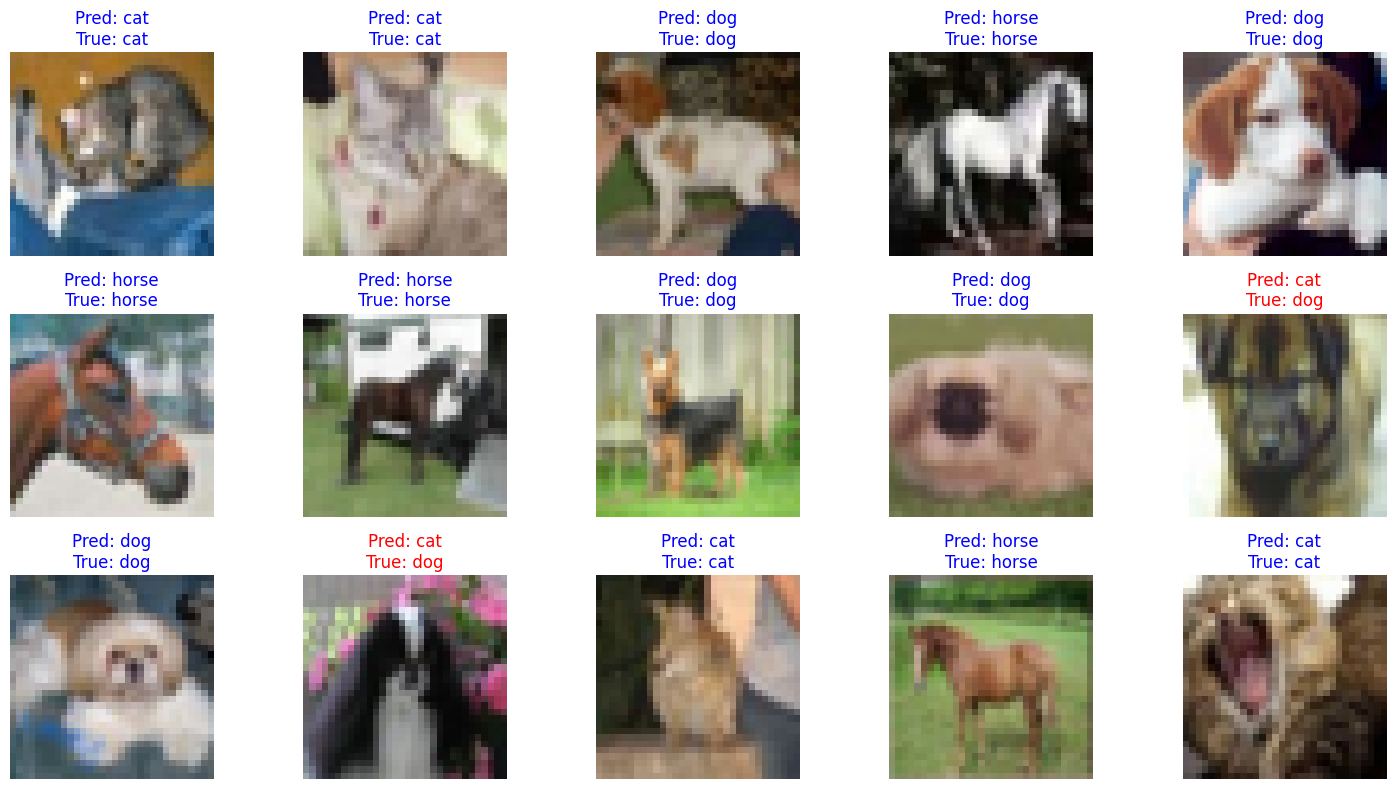

In [5]:
# 학습 과정 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# 최종 평가
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\n최종 테스트 정확도: {acc*100:.2f}%")

# 예측 결과 이미지 시각화
predictions = model.predict(x_test)
plt.figure(figsize=(15, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[i])
    pred_idx = np.argmax(predictions[i])
    true_idx = y_test[i]

    pred_label = selected_classes[pred_idx]
    true_label = selected_classes[true_idx]

    color = 'blue' if pred_idx == true_idx else 'red'
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()